# Lab 1 Task 1

## 1. Implement the following layers as Python functions (both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AI_Lab1

In [2]:
import os
from typing import Callable, Iterable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
class Parameter:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data
        self.grad = None


class Module:
    def __call__(self, *args, **kwargs) -> np.ndarray:
        return self.forward(*args, **kwargs)

    def __repr__(self) -> str:
        layers = '\n'.join([f'  ({k}): {v}' for k, v in self.__dict__.items()])
        return f'{self.__class__.__name__}(\n{layers}\n)'

In [ ]:
class Linear(Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights and biases
        init_factor = 0.01
        self.W = Parameter(np.random.randn(in_features, out_features) * init_factor)
        self.b = Parameter(np.zeros((1, out_features)))

        # Cache for backward pass
        self.x = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W.data) + self.b.data  # Y= WX + b
        return out


    def backward(self, dy):
        dx = np.dot(dy, self.W.data.T)
        self.W.grad = np.dot(self.x.T, dy)
        self.b.grad = np.sum(dy, axis=0, keepdims=True)
        return dx


    def parameters(self):
        return self.W, self.b

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(in_features={self.in_features}, out_features={self.out_features})'


class ReLU(Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = None

    def forward(self, x):
        self.x = x
        return np.maximum(0, x)


    def backward(self, dy):
        dx = dy * (self.x > 0)
        return dx


    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Sigmoid(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        self.y = 1/ (1 + np.exp(-x))
        return self.y


    def backward(self, dy):
        dx = dy * self.y * (1 - self.y)
        return dx


    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Softmax(Module):
    def __init__(self) -> None:
        super().__init__()
        self.y = None

    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.y = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.y


    def backward(self, dy):

        return dy

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [ ]:
class MLP(Module):
    def __init__(self) -> None:
        # Assume the iuput feature of MNIST is 784d
        self.fc1 = Linear(784, 128)
        self.relu1 = ReLU()
        self.fc2 = Linear(128, 10)
        self.softmax = Softmax()

    def forward(self, x):
        # 順序: Linear -> ReLU -> Linear -> Softmax
        x = x.reshape(x.shape[0], -1)
        out = self.fc1(x)
        out = self.relu1.forward(out)
        out = self.fc2.forward(out)
        out = self.softmax.forward(out)
        return out

    def backward(self, dy):
        # 反向順序：Softmax → fc2 → ReLU → fc1
        dy = self.softmax.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.relu1.backward(dy)
        dx = self.fc1.backward(dy)
        return dx
    
    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters()

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(\n{self.fc1}\n{self.relu1}\n{self.fc2}\n{self.softmax}\n)'

## 2. Implement training and testing process
* included cross-validation

In [7]:
class MNIST:
    # root請根據你的檔案位置更改
    def __init__(self, root='/content', train=True, transform: Callable = None) -> None:
        path = os.path.join(root, 'mnist_train.csv' if train else 'mnist_test.csv')
        self.data = np.loadtxt(path, delimiter=',')
        self.transform = transform
        self.image_size = 28
        self.num_classes = 10
        self.classes = np.arange(self.num_classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = (self.data[idx, 0] == self.classes).astype(
            np.float32
        )  # one-hot encoding
        image = (
            self.data[idx, 1:]
            .reshape(self.image_size * self.image_size)
            .astype(np.float32)
        )
        if self.transform:
            image = self.transform(image)
        return image, label


class Subset:
    def __init__(self, dataset, indices: Iterable) -> None:
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


class DataLoader:
    def __init__(self, dataset, batch_size=1) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        for start_idx in range(0, len(self.dataset), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            batch_indices = self.indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                image, label = self.dataset[idx]
                batch_images.append(image)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

In [ ]:
# Separate train_imgs, train_labels into training and validation
# root請根據你的檔案位置更改
def load_mnist_data(
    root="/content", batch_size=1, split_ratio=0.2, transform=None
) -> tuple[DataLoader, DataLoader, DataLoader]:
    def _split_dataset(dataset, split_ratio):
        total_size = len(dataset)
        indices = np.arange(total_size)
        np.random.shuffle(indices)
        split_point = int(total_size * (1 - split_ratio))
        train_indices, valid_indices = indices[:split_point], indices[split_point:]
        train_subset= Subset(dataset, train_indices)
        valid_subset = Subset(dataset, valid_indices)
        return train_subset, valid_subset


    trainset = MNIST(root=root, train=True, transform=transform)
    testset = MNIST(root=root, train=False, transform=transform)
    trainset, validset = _split_dataset(trainset, split_ratio=split_ratio)
    trainldr = DataLoader(trainset, batch_size=batch_size)
    validldr = DataLoader(validset, batch_size=batch_size)
    testldr = DataLoader(testset, batch_size=batch_size)
    return trainldr, validldr, testldr

In [10]:
class CrossEntropyLoss(Module):
    def __init__(self, epsilon=1e-15) -> None:
        super().__init__()
        self.epsilon = epsilon  # small value to avoid log(0)
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        self.y_true = y_true
        batch_size = y_true.shape[0]
        loss = -np.sum(y_true * np.log(self.y_pred)) / batch_size
        return loss

    def backward(self):
        batch_size = self.y_true.shape[0]
        grad = (self.y_pred - self.y_true) / batch_size
        return grad

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


class SGD:
    def __init__(self, params: Iterable, lr: float = 1e-3) -> None:
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.fill(0)

In [12]:
class AdamW:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.params = params
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [np.zeros_like(p.data) for p in params]
        self.v = [np.zeros_like(p.data) for p in params]
        self.t = 0

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas

        for i, p in enumerate(self.params):
            if p.grad is None:
                continue

            # Apply weight decay (AdamW 修正部分)
            if self.weight_decay != 0:
                p.grad += self.weight_decay * p.data

            # 更新一階與二階動量
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * p.grad
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (p.grad ** 2)

            # 偏差修正
            m_hat = self.m[i] / (1 - beta1 ** self.t)
            v_hat = self.v[i] / (1 - beta2 ** self.t)

            # 更新參數
            p.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)


In [13]:
def train_one_epoch(model: Module, trainldr: Iterable, criterion, optimizer) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(trainldr):
        # 1. forward propagation
        out = model.forward(x)
        # 2. compute loss
        loss = criterion.forward(out, y)
        # 3. compute accuracy
        preds = np.argmax(out, axis=1)
        labels = np.argmax(y, axis=1)
        correct += np.sum(preds == labels)
        total += len(y)
        total_loss += loss*len(y)
        # 4. backward propagation
        dy = criterion.backward()
        model.backward(dy)
        # 5. update parameters
        optimizer.step()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model: Module, testldr: Iterable) -> tuple[float, float]:
    total = 0
    correct = 0
    total_loss = 0
    criterion = CrossEntropyLoss()  # separate criterion from training
    for x, y in tqdm(testldr):
        # 1. forward propagation
        out = model.forward(x)
        # 2. compute total loss
        loss = criterion.forward(out, y)
        total_loss += loss*len(y)
        # 3. compute correct and total
        preds = np.argmax(out, axis=1)
        labels = np.argmax(y, axis=1)
        correct += np.sum(preds == labels)
        total += len(y)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train(model: MLP, trainldr: Iterable, validldr: Iterable, epochs=10, lr=1e-3):
    criterion = CrossEntropyLoss()
    # 這邊提供SGD作為optimizer，同學也可以根據自己人需求更換其他optimizer
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, trainldr, criterion, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f'epoch {epoch:d}: train_loss = {loss}, train_acc = {acc}')

        loss, acc = evaluate(model, validldr)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f'epoch {epoch:d}: valid_loss = {loss}, valid_acc = {acc}\n')

    return train_loss, train_acc, valid_loss, valid_acc

In [16]:
def transform(x):
    """map pixels information from range(0, 255) to range(0.01, 1)"""
    return np.asarray(x) * 0.99 + 0.01

# "../data"請根據你的檔案位置更改
trainldr, validldr, testldr = load_mnist_data(
    "/content", batch_size=32, transform=transform
)
print(f"train set: {len(trainldr)} images")
print(f"validation set: {len(validldr)} images")
print(f"test set: {len(testldr)} images")
for x, y in trainldr:
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

net = MLP()
print(net)
# 你可以調整 epochs 和 lr 來觀察不同的訓練效果
train_loss, train_acc, valid_loss, valid_acc = train(
    net, trainldr, validldr, epochs=20, lr=1e-4)

train set: 1688 images
validation set: 188 images
test set: 313 images
x shape: (32, 784)
y shape: (32, 10)
MLP(
Linear(in_features=784, out_features=128)
ReLU()
Linear(in_features=128, out_features=10)
Softmax()
)


100%|██████████| 1688/1688 [00:09<00:00, 177.39it/s]


epoch 0: train_loss = 0.25598615456912927, train_acc = 0.9226481481481481


100%|██████████| 188/188 [00:00<00:00, 807.22it/s]


epoch 0: valid_loss = 0.15455571092629444, valid_acc = 0.9561666666666667



100%|██████████| 1688/1688 [00:07<00:00, 217.34it/s]


epoch 1: train_loss = 0.10740462296977478, train_acc = 0.9672592592592593


100%|██████████| 188/188 [00:01<00:00, 130.16it/s]


epoch 1: valid_loss = 0.12270090924001432, valid_acc = 0.9645



100%|██████████| 1688/1688 [00:07<00:00, 211.44it/s]


epoch 2: train_loss = 0.07340537760314424, train_acc = 0.9776481481481482


100%|██████████| 188/188 [00:00<00:00, 782.56it/s]


epoch 2: valid_loss = 0.11691440152039455, valid_acc = 0.967



100%|██████████| 1688/1688 [00:09<00:00, 185.74it/s]


epoch 3: train_loss = 0.054175118574920016, train_acc = 0.9835185185185186


100%|██████████| 188/188 [00:00<00:00, 416.47it/s]


epoch 3: valid_loss = 0.12195567465658096, valid_acc = 0.9646666666666667



100%|██████████| 1688/1688 [00:06<00:00, 262.67it/s]


epoch 4: train_loss = 0.04145105017054674, train_acc = 0.9874814814814815


100%|██████████| 188/188 [00:00<00:00, 781.18it/s]


epoch 4: valid_loss = 0.12458342672188732, valid_acc = 0.9665



100%|██████████| 1688/1688 [00:10<00:00, 165.27it/s]


epoch 5: train_loss = 0.033421106937171007, train_acc = 0.9900740740740741


100%|██████████| 188/188 [00:00<00:00, 780.74it/s]


epoch 5: valid_loss = 0.11203463201409056, valid_acc = 0.9716666666666667



100%|██████████| 1688/1688 [00:06<00:00, 276.01it/s]


epoch 6: train_loss = 0.0299576384978072, train_acc = 0.9905555555555555


100%|██████████| 188/188 [00:00<00:00, 790.50it/s]


epoch 6: valid_loss = 0.11393802563866268, valid_acc = 0.9723333333333334



100%|██████████| 1688/1688 [00:09<00:00, 176.62it/s]


epoch 7: train_loss = 0.02648124631649126, train_acc = 0.9914814814814815


100%|██████████| 188/188 [00:00<00:00, 789.22it/s]


epoch 7: valid_loss = 0.1113057705310109, valid_acc = 0.9718333333333333



100%|██████████| 1688/1688 [00:12<00:00, 132.91it/s]


epoch 8: train_loss = 0.023597379873329726, train_acc = 0.992462962962963


100%|██████████| 188/188 [00:00<00:00, 413.83it/s]


epoch 8: valid_loss = 0.1132091777459888, valid_acc = 0.9733333333333334



100%|██████████| 1688/1688 [00:09<00:00, 179.86it/s]


epoch 9: train_loss = 0.02140482170388736, train_acc = 0.9932777777777778


100%|██████████| 188/188 [00:01<00:00, 144.64it/s]


epoch 9: valid_loss = 0.10574483672099685, valid_acc = 0.9753333333333334



100%|██████████| 1688/1688 [00:08<00:00, 193.72it/s]


epoch 10: train_loss = 0.02090267378318468, train_acc = 0.9931666666666666


100%|██████████| 188/188 [00:00<00:00, 684.26it/s]


epoch 10: valid_loss = 0.11725089269696595, valid_acc = 0.9728333333333333



100%|██████████| 1688/1688 [00:08<00:00, 195.81it/s]


epoch 11: train_loss = 0.02003149245473262, train_acc = 0.9933148148148148


100%|██████████| 188/188 [00:00<00:00, 315.91it/s]


epoch 11: valid_loss = 0.14319280905467735, valid_acc = 0.9653333333333334



100%|██████████| 1688/1688 [00:06<00:00, 250.49it/s]


epoch 12: train_loss = 0.019097721409724634, train_acc = 0.9936851851851852


100%|██████████| 188/188 [00:00<00:00, 678.57it/s]


epoch 12: valid_loss = 0.112984985326845, valid_acc = 0.976



100%|██████████| 1688/1688 [00:09<00:00, 175.89it/s]


epoch 13: train_loss = 0.01684359928100691, train_acc = 0.9947962962962963


100%|██████████| 188/188 [00:00<00:00, 769.86it/s]


epoch 13: valid_loss = 0.12738487459486636, valid_acc = 0.973



100%|██████████| 1688/1688 [00:06<00:00, 274.96it/s]


epoch 14: train_loss = 0.01756418425255246, train_acc = 0.9941851851851852


100%|██████████| 188/188 [00:00<00:00, 773.88it/s]


epoch 14: valid_loss = 0.13060935643238356, valid_acc = 0.9725



100%|██████████| 1688/1688 [00:09<00:00, 178.43it/s]


epoch 15: train_loss = 0.017027068700555953, train_acc = 0.9944259259259259


100%|██████████| 188/188 [00:00<00:00, 688.42it/s]


epoch 15: valid_loss = 0.1196800132054152, valid_acc = 0.9723333333333334



100%|██████████| 1688/1688 [00:06<00:00, 275.27it/s]


epoch 16: train_loss = 0.018453372271084678, train_acc = 0.9936296296296296


100%|██████████| 188/188 [00:00<00:00, 706.94it/s]


epoch 16: valid_loss = 0.12163928887583142, valid_acc = 0.9725



100%|██████████| 1688/1688 [00:09<00:00, 178.17it/s]


epoch 17: train_loss = 0.01701492242320126, train_acc = 0.9943148148148148


100%|██████████| 188/188 [00:00<00:00, 741.23it/s]


epoch 17: valid_loss = 0.12130683993734251, valid_acc = 0.9721666666666666



100%|██████████| 1688/1688 [00:06<00:00, 277.91it/s]


epoch 18: train_loss = 0.015310595119906279, train_acc = 0.9952222222222222


100%|██████████| 188/188 [00:00<00:00, 691.18it/s]


epoch 18: valid_loss = 0.14851177972031204, valid_acc = 0.9673333333333334



100%|██████████| 1688/1688 [00:09<00:00, 178.35it/s]


epoch 19: train_loss = 0.015409307934762738, train_acc = 0.9947962962962963


100%|██████████| 188/188 [00:00<00:00, 693.52it/s]

epoch 19: valid_loss = 0.11764499453515316, valid_acc = 0.973



In [17]:
# Using test_images and test_labels to do the final test
test_loss, test_acc = evaluate(net, testldr)
print(f"test_loss = {test_loss}, test_acc = {test_acc}")

100%|██████████| 313/313 [00:00<00:00, 801.78it/s]

test_loss = 0.10892178415646085, test_acc = 0.9736


## 3. Plot loss & accuracy curves(both Training and Validation)

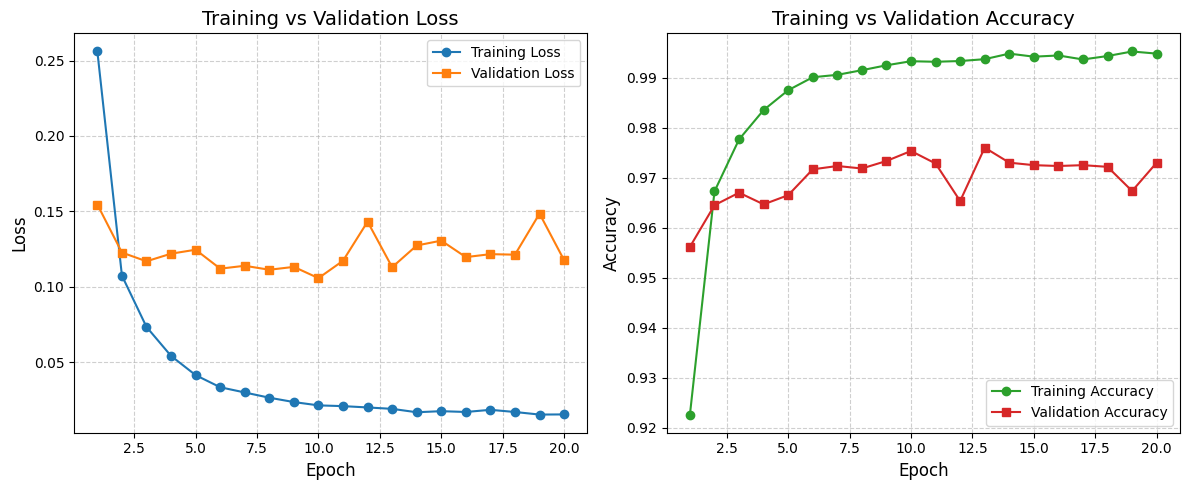

In [18]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))
# --------------------------
# Loss 曲線
# --------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", color="#1f77b4", marker="o")
plt.plot(epochs, valid_loss, label="Validation Loss", color="#ff7f0e", marker="s")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
# --------------------------
# Accuracy 曲線
# --------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy", color="#2ca02c", marker="o")
plt.plot(epochs, valid_acc, label="Validation Accuracy", color="#d62728", marker="s")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training vs Validation Accuracy", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
# --------------------------
# 顯示圖表
# --------------------------
plt.tight_layout()
plt.show()
